# Data processing and visualization

## 1. Combine data & calculate RMSE

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

days = 32
discretization = 2
obs_per_day = 1
nobs = days * obs_per_day
MAGI_niter = 15001
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]


tmp_2 = np.linspace(0, 2 * T * np.pi, discretization * nobs)
true_re_2 = parameter_value[0] - std[0] * np.cos(tmp_2)
true_ve_2 = parameter_value[1]- std[1] * np.cos(tmp_2)
true_vi_2 = parameter_value[2]
true_pd_2 = parameter_value[3] + std[3] * np.cos(tmp_2)
theta_true = np.vstack([true_re_2, true_ve_2, true_pd_2]).T

tmp = np.linspace(0, 2 * T * np.pi, nobs)
true_re = parameter_value[0] - std[0] * np.cos(tmp)
true_ve = parameter_value[1]- std[1] * np.cos(tmp)
true_vi = parameter_value[2] 
true_pd = parameter_value[3] + std[3] * np.cos(tmp)

all_beta = np.zeros((100, 64))
all_ve = np.zeros((100, 64))
all_pd = np.zeros((100, 64))
all_vi = np.zeros(100)
all_xinit = np.zeros((100, 4))
RMSE_beta = np.zeros(100)
for i in range(100):
    file = np.load('G:/TVMAGI-2/beta_'+str(i)+'-dis=2.npy')
    all_beta[i] = file

for i in range(100):
    file = np.load('G:/TVMAGI-2/ve_'+str(i)+'-dis=2.npy')
    all_ve[i] = file  
    
for i in range(100):
    file = np.load('G:/TVMAGI-2/pd_'+str(i)+'-dis=2.npy')
    all_pd[i] = file  

for i in range(100):
    file = np.load('G:/TVMAGI-2/vi_'+str(i)+'-dis=2.npy')
    all_vi[i] = file 

for i in range(100):
    file = np.load('G:/TVMAGI-2/xinit_'+str(i)+'-dis=2.npy')
    all_xinit[i] = file
RMSE_beta = np.sqrt(np.mean(np.square(all_beta - true_re_2), axis=0))
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_ve = np.sqrt(np.mean(np.square(all_ve - true_ve_2), axis=0))
print(np.mean(RMSE_ve), np.std(RMSE_ve))
RMSE_vi = np.abs(all_vi - true_vi_2)
print(np.mean(RMSE_vi), np.std(RMSE_vi))
RMSE_pd = np.sqrt(np.mean(np.square(all_pd / 4 - true_pd_2), axis=0))
print(np.mean(RMSE_pd), np.std(RMSE_pd))


0.11217061664885354 0.033560491146914354
0.008636731966961912 0.010449043913094924
0.00632226658582675 0.003851056101770135
0.020367274498285858 0.03288536371642093


## 2. Visualization of parameters

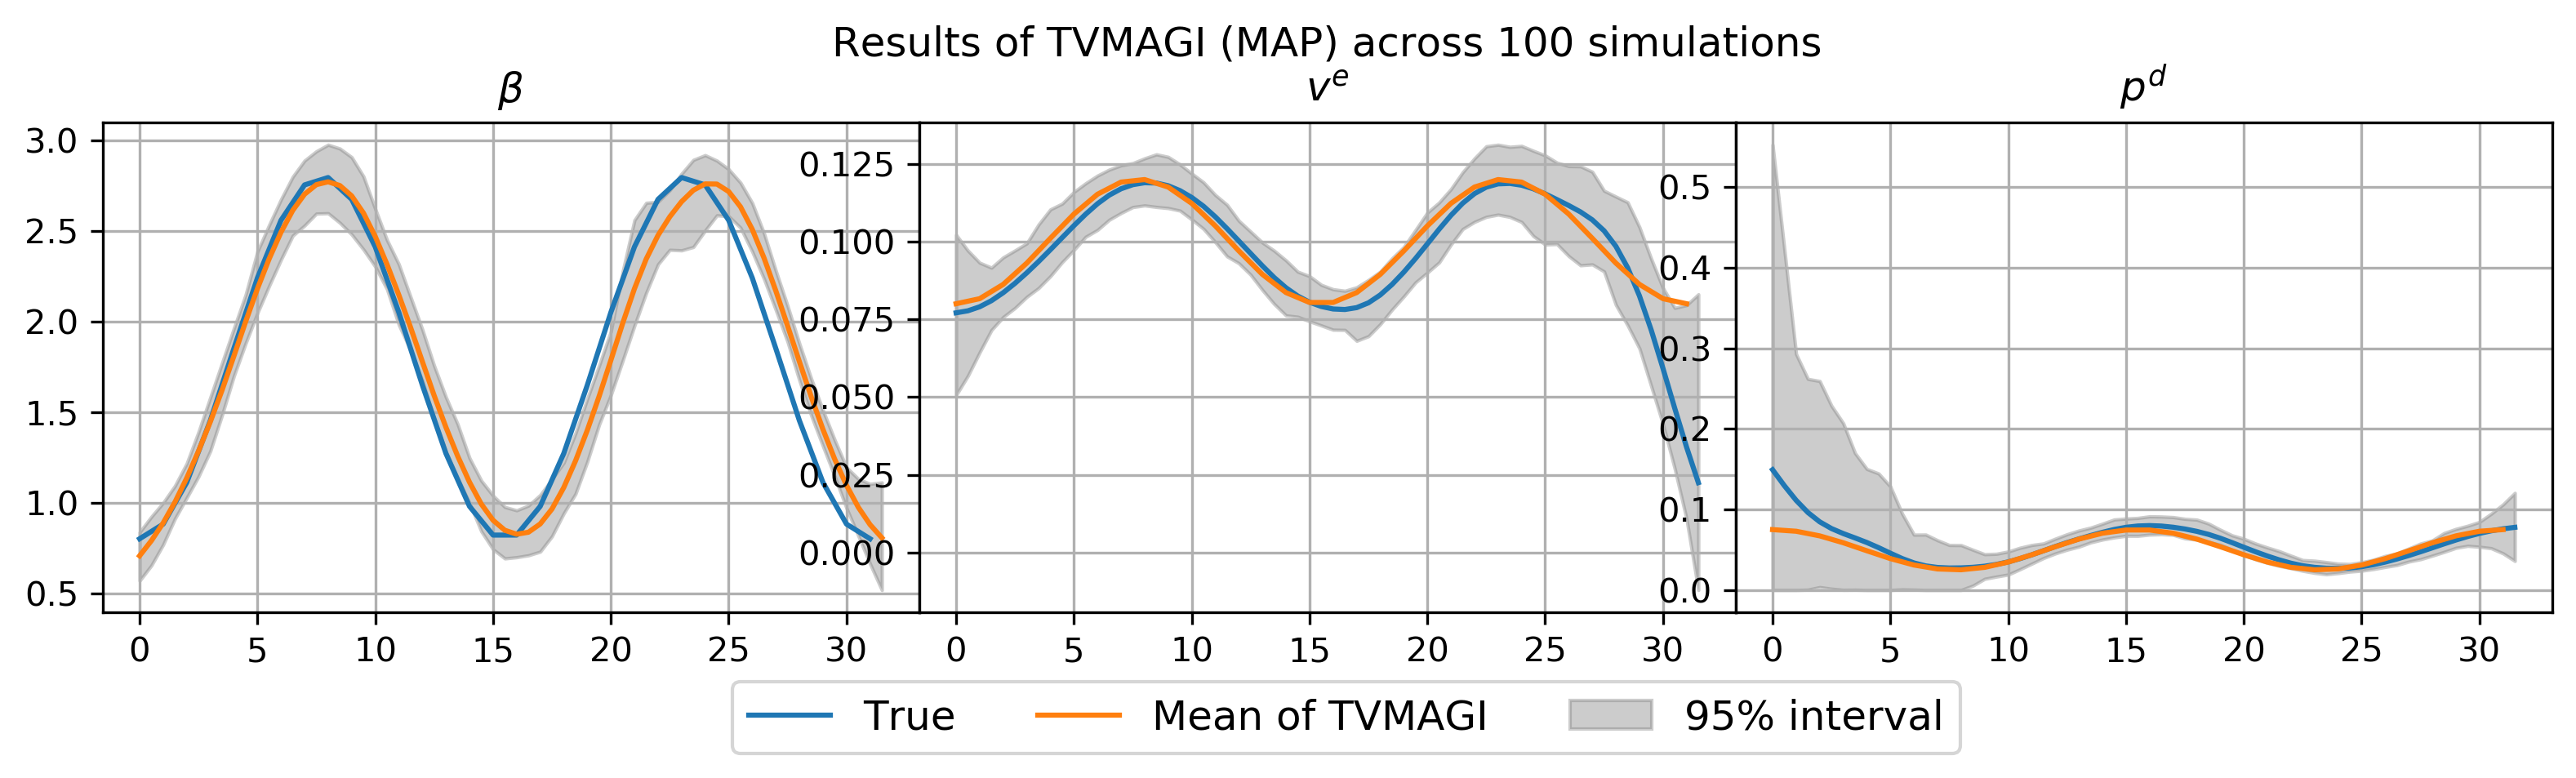

In [2]:
all_beta = np.zeros((100, 64))
RMSE_beta = np.zeros(100)
for i in range(100):
    file = np.load('G:/TVMAGI-2/beta_'+str(i)+'-dis=2.npy')
    all_beta[i] = file
RMSE_beta = np.sqrt(np.mean(np.square(all_beta - true_re_2), axis=0))    


%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 3, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)
x = np.arange(0, 32, 0.5)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_re, label='True')
plt.plot(x, np.mean(all_beta, axis=0), label=r'Mean of TVMAGI')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(2.3, -0.1), fontsize=12, ncol=3)

ax2 = plt.subplot(1, 3, 2)
lower_95 = np.percentile(all_ve, 97.5, axis=0)
upper_95 = np.percentile(all_ve, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_ve, axis=0))
plt.plot(true_ve)
plt.grid()
plt.title(r'$v^e$')


ax3 = plt.subplot(1, 3, 3)
lower_95 = np.percentile(all_pd, 97.5, axis=0)
upper_95 = np.percentile(all_pd, 2.5, axis=0)
plt.fill_between(x, lower_95/ 4, upper_95/ 4, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_pd, axis=0)/ 4)
plt.plot(true_pd)
plt.title(r'$p^d$')
plt.suptitle(r'Results of TVMAGI (MAP) across 100 simulations', y=1.2)
plt.grid()

## 3. Recover data

In [7]:
def recover_data(beta, ve, pd, vi, state0, days=32, obs_per_day=1, discretization = 1, linspace=1000, mode='Linear'):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]
    # Use linear interpolation for theta
    if mode == 'Linear': 
        x_initial = np.linspace(0, 1000, beta.shape[0])
        x_interp = np.linspace(0, 1000, 32000)
        beta_interp = np.interp(x_interp, x_initial, beta)
        ve_interp = np.interp(x_interp, x_initial, ve)
        pd_interp = np.interp(x_interp, x_initial, pd)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        from scipy.interpolate import Rbf
        x = np.linspace(0, 100, beta.shape[0])
        x_interp = np.linspace(0, 100, 32000)
        rbf_beta = Rbf(x, beta, epsilon=10, function='gaussian')
        rbf_ve = Rbf(x, ve, epsilon=10, function='gaussian')
        rbf_pd = Rbf(x, pd, epsilon=10, function='gaussian')
        beta_interp = rbf_beta(x_interp) 
        ve_interp = rbf_ve(x_interp)
        pd_interp = rbf_pd(x_interp)
    else:
        raise ValueError
        
        
    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve_interp[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve_interp[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd_interp[index]
#     states = state_ls[::int(linspace / discretization)]
    return state_ls


all_reconstructed_x = np.zeros((100, 32000, 4))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_beta[i], all_ve[i], all_pd[i], all_vi[i], np.exp(all_xinit[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


## 4. True data

In [8]:
def true_data(days=32, obs_per_day=1, state0=[100000., 100., 50., 50.], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    parameter_value = [1.8, 0.1, 0.1, 0.05]
    std = [1., 0.02, 0, 0.025]
    tmp = np.linspace(0, 2 * T * np.pi, 32000)
    true_re = parameter_value[0] - std[0] * np.cos(tmp)
    true_ve = parameter_value[1]- std[1] * np.cos(tmp)
    true_vi = parameter_value[2] 
    true_pd = parameter_value[3] + std[3] * np.cos(tmp)
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi  * true_pd[index]
    states = state_ls[::linspace]
    return states

true_x = true_data()
true_x

array([[1.00000000e+05, 1.00000000e+02, 5.00000000e+01, 5.00000000e+01],
       [9.99571525e+04, 1.33476557e+02, 5.41824154e+01, 5.03857686e+01],
       [9.99011332e+04, 1.76643597e+02, 6.12909975e+01, 5.07912735e+01],
       [9.98177422e+04, 2.41614832e+02, 7.30440138e+01, 5.12158373e+01],
       [9.96857153e+04, 3.45756180e+02, 9.27273692e+01, 5.16641612e+01],
       [9.94703981e+04, 5.16912554e+02, 1.26095735e+02, 5.21488671e+01],
       [9.91140083e+04, 8.01313684e+02, 1.82888184e+02, 5.26951891e+01],
       [9.85239427e+04, 1.27267873e+03, 2.78916255e+02, 5.33562761e+01],
       [9.75657351e+04, 2.03664793e+03, 4.37965090e+02, 5.42559911e+01],
       [9.60757419e+04, 3.21769208e+03, 6.91388425e+02, 5.56835898e+01],
       [9.39125168e+04, 4.91313828e+03, 1.07218908e+03, 5.82532884e+01],
       [9.10457137e+04, 7.11753927e+03, 1.60217434e+03, 6.30825297e+01],
       [8.76303793e+04, 9.66479585e+03, 2.27741643e+03, 7.18436100e+01],
       [8.39821807e+04, 1.22601244e+04, 3.06398194e

## 5. Visualization of $x(t)$ using linear interpolation

769.6073802789466 258.8968013245301
711.5010410795264 191.56844924651986
427.44660032109243 142.62862158067725
39.8358146849766 6.149334778659096


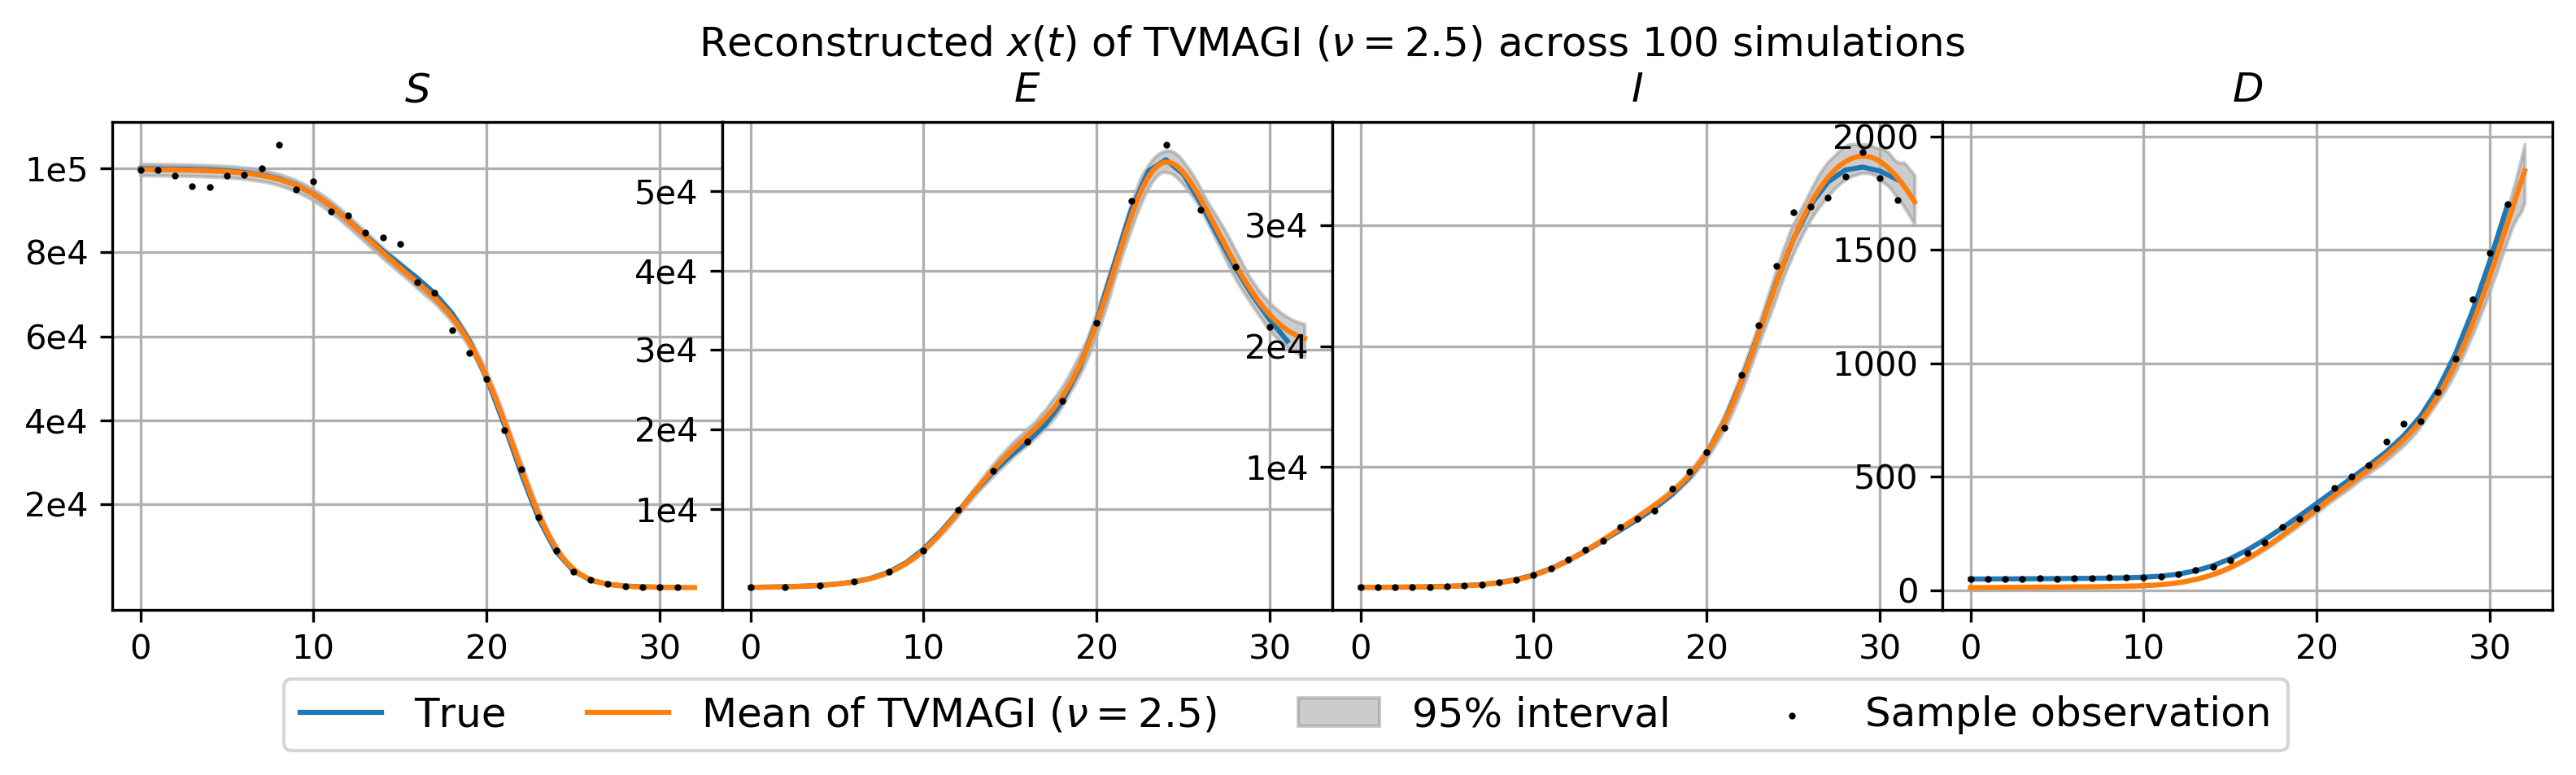

In [12]:
yobs = np.exp(np.load('G:/TVMAGI-2/SEIRD_observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 32, 0.001)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0), label=r'Mean of TVMAGI ($\nu=2.5$)')
plt.scatter(np.arange(0, 32,1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(all_reconstructed_x[:,:, 2], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 2], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 3], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 3], 2.5, axis=0)
# plt.yticks(np.array([250,500,750,1000,1250,1500]))
plt.fill_between(x, lower_95/4, upper_95/4, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 3], axis=0)/4)
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')

plt.suptitle(r'Reconstructed $x(t)$ of TVMAGI ($\nu=2.5$) across 100 simulations', y=1.2)

RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 3] / 4 - true_x[:, 3])))
    
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

## 6. parameter using Gaussian process interpolation

In [88]:
import pickle

def MaternKernel(d, phi_1, phi_2, nu=2.5):
    """
    construct a kernel given time points and hyper parameters
    """
    if nu == 2.5:  
        a = np.square(phi_1) * (
                1. + np.sqrt(5) * d / phi_2 + 5. * np.square(d) / (3. * np.square(phi_2))) * np.exp(
            -np.sqrt(5) * d / phi_2)
        return a
    else:
        a = np.square(phi_1) * (1. + np.sqrt(3) * d / phi_2) * np.exp(-np.sqrt(3) * d / phi_2)       
        return a

def GPinterp(x, y, phi_1, phi_2, inv_cov, discretization=2, days=32, obs_per_day=1):
    x_obs = np.arange(0, 32, 1 / discretization)
    return y.T.dot(inv_cov).dot(MaternKernel(np.abs(x_obs - x), phi_1, phi_2, nu=2.5))
    

def recover_data(beta, ve, pd, vi, state0, days=32, obs_per_day=1, discretization = 1, linspace=1000, mode='Linear', hyper=None):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    global d_matrix
    freq = 1. / discretization
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]
    # Use linear interpolation for theta
    if mode == 'Linear': 
        x_initial = np.linspace(0, 1000, beta.shape[0])
        x_interp = np.linspace(0, 1000, 32000)
        beta_interp = np.interp(x_interp, x_initial, beta)
        ve_interp = np.interp(x_interp, x_initial, ve)
        pd_interp = np.interp(x_interp, x_initial, pd)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        beta_interp = np.zeros(32000)
        ve_interp = np.zeros(32000)
        pd_interp = np.zeros(32000)
        beta_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[0][0], hyper[0][1]))
        ve_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[1][0], hyper[1][1]))
        pd_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[2][0], hyper[2][1]))
        for i in range(32000):
            beta_interp[i] = GPinterp(i / 1000, beta, hyper[0][0], hyper[0][1], beta_inv_cov)
            ve_interp[i] = GPinterp(i / 1000, ve, hyper[1][0], hyper[1][1], ve_inv_cov)
            pd_interp[i] = GPinterp(i / 1000, pd, hyper[2][0], hyper[2][1], pd_inv_cov)
    else:
        raise ValueError
        
        
    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * beta_interp[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * ve_interp[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * ve_interp[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * vi * pd_interp[index]
#     states = state_ls[::int(linspace / discretization)]
    return state_ls

n_points = days * discretization
d_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)    
all_reconstructed_x = np.zeros((100, 32000, 4))
for i in range(100):
    print(i)
    file = open('G:/TVMAGI-2/hyper_' + str(i) + '-dis=2.txt','rb')
    hyper_ls = pickle.load(file)
    all_reconstructed_x[i] = recover_data(all_beta[i], all_ve[i], all_pd[i], all_vi[i], np.exp(all_xinit[i]), mode='Gaussian', hyper=hyper_ls)

## 7. Reconstructed $x(t)$ using Gaussian process interpolation

581.7440886312645 272.18161573579255
704.7770318467716 218.31278582765006
439.0305458329514 140.43083929198275
38.317402348537215 4.911127466415913


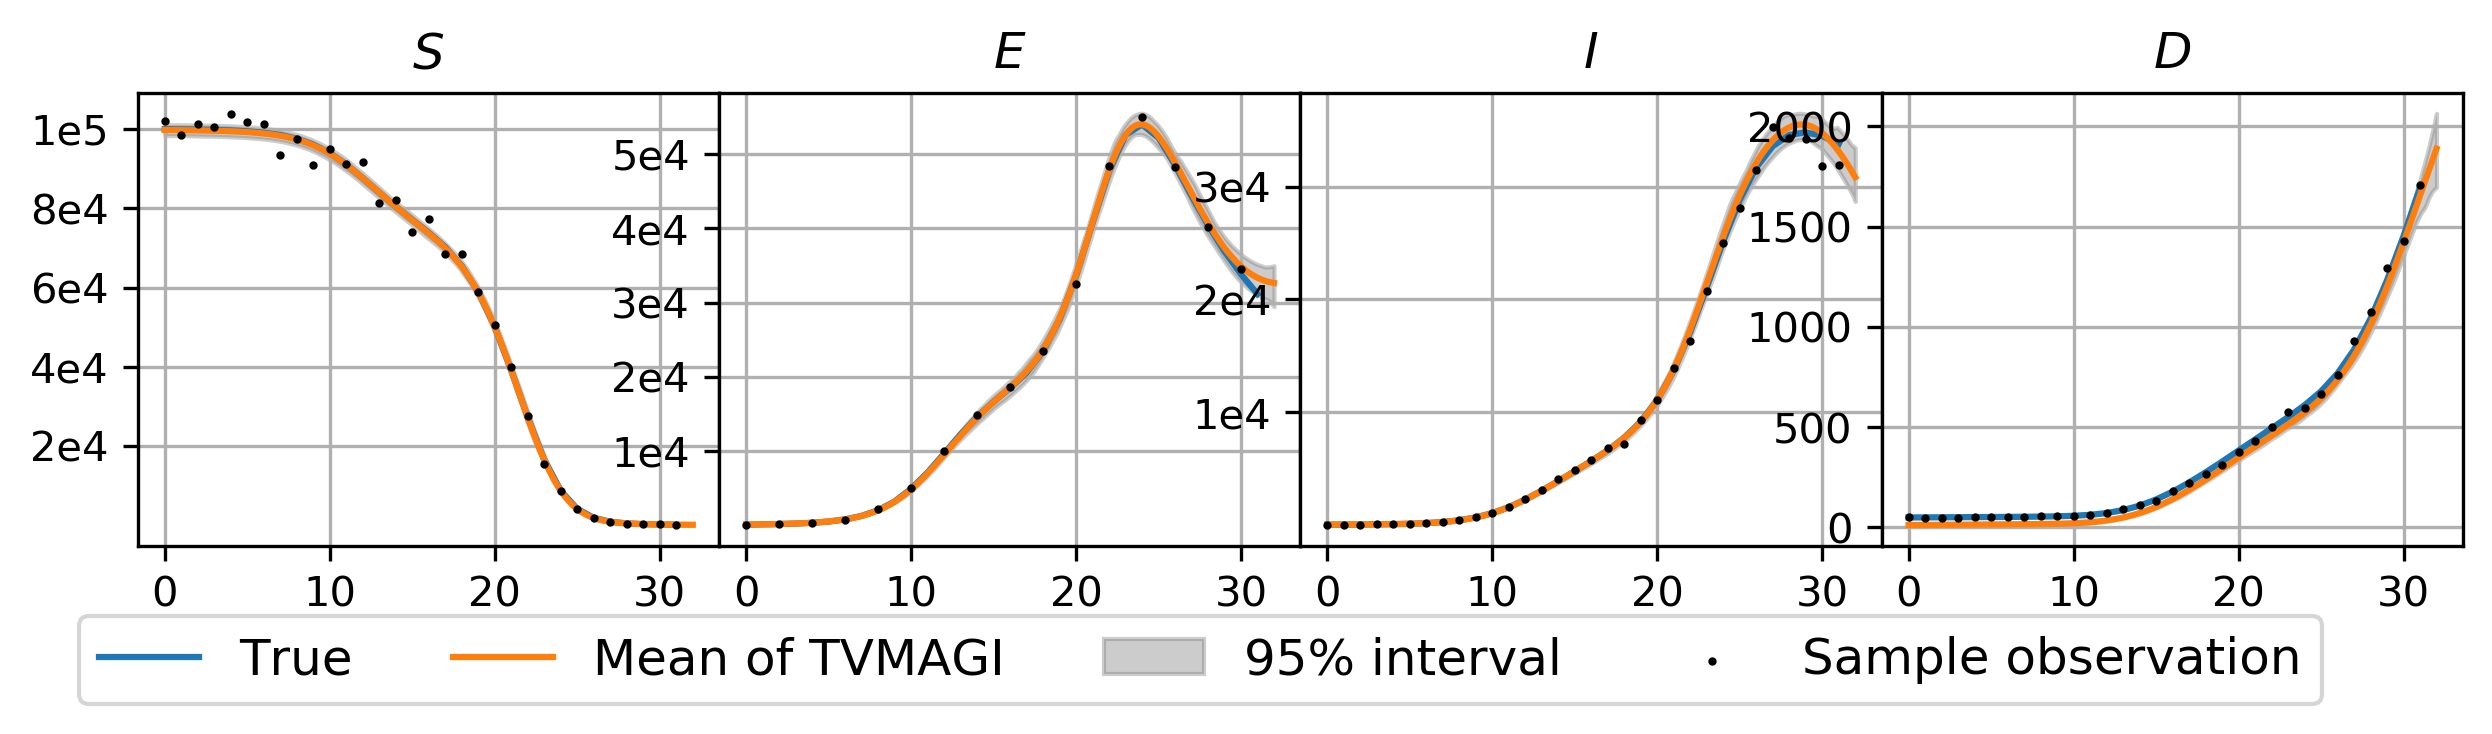

In [87]:
yobs = np.exp(np.load('G:/TVMAGI-2/observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 32, 0.001)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0), label='Mean of TVMAGI')
plt.scatter(np.arange(0, 32,1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.8, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(all_reconstructed_x[:,:, 2], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 2], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 3], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 3], 2.5, axis=0)
# plt.yticks(np.array([250,500,750,1000,1250,1500]))
plt.fill_between(x, lower_95/4, upper_95/4, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 3], axis=0)/4)
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')

RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::1000, 3] / 4 - true_x[:, 3])))
    
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

In [ ]:
import numpy as np
import torch
import time
torch.set_num_threads(1)
torch.set_default_dtype(torch.double)

def RungeKutta_SEIR(x_init, beta, ve, vi, pd, yobs):
    discretization = 2
    step_size = 1 / nsteps
    tensor_ls = [[0 for i in range(4)] for j in range(discretization * 32)]
    tensor_ls[0][0] = x_init
    w_ls = [0 for j in range(discretization * 32)]
    w_ls[0] = x_init
    for i in range(1, discretization * 32):
        idx = int(i)
        # k_1
        tensor_ls[i][0] = torch.stack((-step_size * beta[idx] * torch.exp(w_ls[i-1][2]) / 100000,
                      step_size * beta[idx] * torch.exp(w_ls[i-1][0]+w_ls[i-1][2]-w_ls[i-1][1]) / 100000 -
                                    step_size * ve[idx],
                      step_size * ve[idx] * torch.exp(w_ls[i-1][1] - w_ls[i-1][2]) -
                                    step_size * vi,
                      step_size * pd[idx] * vi * torch.exp(w_ls[i-1][2] - w_ls[i-1][3])))
        # k_2
        w2 = w_ls[i-1] + tensor_ls[i][0] / 2
        tensor_ls[i][1] = torch.stack((-step_size * beta[idx] * torch.exp(w2[2]) / 100000,
                      step_size * beta[idx] * torch.exp(w2[0]+w2[2]-w2[1]) / 100000 -
                                    step_size * ve[idx],
                      step_size * ve[idx] * torch.exp(w2[1] - w2[2]) -
                                    step_size * vi,
                      step_size * pd[idx] * vi * torch.exp(w2[2] - w2[3])))
        # k_3
        w3 = w_ls[i-1] + tensor_ls[i][1] / 2
        tensor_ls[i][2] = torch.stack((-step_size * beta[idx] * torch.exp(w3[2]) / 100000,
                      step_size * beta[idx] * torch.exp(w3[0]+w3[2]-w3[1]) / 100000 -
                                    step_size * ve[idx],
                      step_size * ve[idx] * torch.exp(w3[1] - w3[2]) -
                                    step_size * vi,
                      step_size * pd[idx] * vi * torch.exp(w3[2] - w3[3])))
        # k_3
        w4 = w_ls[i-1] + tensor_ls[i][2]
        tensor_ls[i][3] = torch.stack((-step_size * beta[idx] * torch.exp(w4[2]) / 100000,
                      step_size * beta[idx] * torch.exp(w4[0]+w4[2]-w4[1]) / 100000 -
                                    step_size * ve[idx],
                      step_size * ve[idx] * torch.exp(w4[1] - w4[2]) -
                                    step_size * vi,
                      step_size * pd[idx] * vi * torch.exp(w4[2] - w4[3])))
        w_ls[i] = w_ls[i-1] + (tensor_ls[i][0] + 2 * tensor_ls[i][1] + 2 * tensor_ls[i][2] + tensor_ls[i][3]) / 6
    mse = torch.zeros([days * discretization,1])
    for i in range(days * discretization):
        mse[i] = torch.sum(torch.square(w_ls[int(discretization * i)] - yobs[i]))
    return torch.sum(mse)


def RK_solver(use_data_idx, days=32, discretization=2):
    start_time = time.time()
    yobs = observations[use_data_idx]
    yobs[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
    yobs = torch.tensor(yobs)
    x_init = torch.tensor(yobs[0], requires_grad = True, dtype = torch.float64)
    beta = torch.tensor(1.8 * np.ones(days * discretization), requires_grad=True, dtype = torch.float64)
    ve = torch.tensor(0.1 * np.ones(days * discretization), requires_grad=True, dtype = torch.float64)
    pd = torch.tensor(0.2 * np.ones(days * discretization), requires_grad=True, dtype = torch.float64)
    vi = torch.tensor(0.1, requires_grad=True, dtype = torch.float64)
    optimizer = torch.optim.Adam([x_init, beta, ve, vi, pd], lr=1e-4)  # , weight_decay = 1.0
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    cur_loss = float('inf')
    for epoch in range(1000000):
        if epoch % 5 == 0:
            print(epoch)
        optimizer.zero_grad()
        # compute loss function
        loss = RungeKutta_SEIR(x_init, beta, ve, vi, pd, torch.tensor(yobs))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if epoch % 100 == 0:
            print(epoch, loss.item())
            if torch.isnan(loss) == False and loss.item() - cur_loss > -0.001 and loss.item() - cur_loss < 0.001:
                print(cur_loss, loss.item())
                break
            cur_loss = loss.item()
            
    
    np.save('TVMAGI-RK-results/time-' + str(use_data_idx) + '.npy', np.array(time.time() - start_time))
    np.save('TVMAGI-RK-results/beta-' + str(use_data_idx) + '.npy', beta.detach().numpy())
    np.save('TVMAGI-RK-results/xinit-' + str(use_data_idx) + '.npy', x_init.detach().numpy())
    np.save('TVMAGI-RK-results/ve-' + str(use_data_idx) + '.npy', ve.detach().numpy())
    np.save('TVMAGI-RK-results/pd-' + str(use_data_idx) + '.npy', pd.detach().numpy())
    np.save('TVMAGI-RK-results/vi-' + str(use_data_idx) + '.npy', np.array(vi.item()))
    
    



from multiprocessing import Pool

if __name__ ==  '__main__': 
    torch.set_num_threads(1)
    observations = np.load('SEIRD_observations.npy')
    N = 100000.
    pool = Pool(processes=1)
    results = pool.map(RK_solver, range(1))
    pool.close()
    pool.join()